In [1]:
%load_ext autoreload
%autoreload 2

# Doc-ID Reassignment

## 1. Data download

### Downloader instance

We download [RCV1 dataset](https://paperswithcode.com/dataset/rcv1), in particular we use tf-idf representation from [sklearn](https://scikit-learn.org/0.18/datasets/rcv1.html).

Create an instance of downloader.

In [2]:
from model.dataset import RCV1Downloader

downloader = RCV1Downloader()
downloader

ImportError: cannot import name 'load_jsonand' from 'io_' (/home/sebaq/Documents/GitHub/IR_project/io_.py)

### Download

Download the dataset.

In [ ]:
%%time

downloader.download()

## 2. Data Loading

### Loading collection configurations

Use dataset configuration specified in the *.settings.py* file.

In [7]:
from settings import DATACONFIG

config = DATACONFIG["tiny"]
config

tiny [Docs: 50000; Terms: 15000; Approximation error: 0.3; N Clusters: 150]

### Loader instance

Create an instance of dataloader.

In [8]:
from model.dataset import RCV1Loader

loader = RCV1Loader()
loader

RCV1Loader [File: /home/sebaq/Documents/GitHub/IR_project/dataset/data.npz]

### Load

We load data sorting:
 - documents (rows) by decreasing number of distinct terms.
 - terms (columns) by decreasing frequency.

We only keep the first documents and terms specified by the configuration file.

In [9]:
collection = loader.load(n_docs=config.docs, n_terms=config.terms)

INFO: Loading matrix. 
I/O: Loading /home/sebaq/Documents/GitHub/IR_project/dataset/data.npz. 
INFO: Removing non informative terms. 
INFO: Sorting documents by terms count. 
INFO: Sorting terms by their frequency. 


In [10]:
collection

DataCollection [Docs: 50000; Terms: 14980; Nonzero: 1314210]

## 3. Computing *d*-gap

### *d*-gap instance

Create and instance of DGapComputation for the collection.

In [28]:
from model.dataset import DGapComputation

dgap = DGapComputation(collection=collection, data_name=config.name)
dgap

DGapComputation[Docs: 50000; Terms: 14980; Computed: False]

### Compute *d*-gap statistics

We compute *d*-gap in the given collection.

In [29]:
%%time

dgap.compute_gaps_stats()

INFO: Try to retrieve gaps info from disk
I/O: Loading /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/d-gap_stats.json 
CPU times: user 8.79 ms, sys: 54 µs, total: 8.84 ms
Wall time: 8.5 ms


In [30]:
gaps_stats = dgap.gaps_stats

### Total *d*-gap per term plot

<class 'numpy.ndarray'>


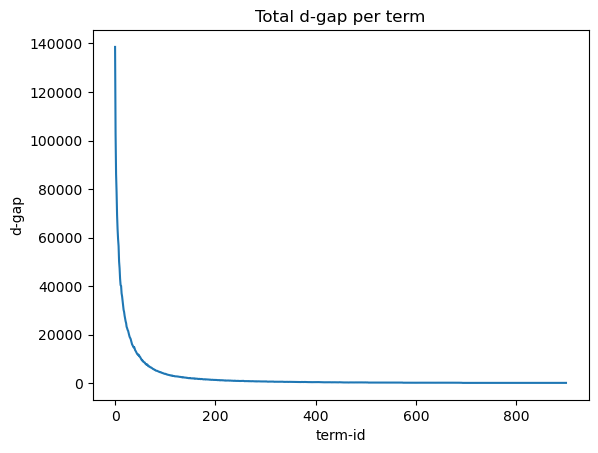

In [31]:
dgap.plot_tot_d_gap()

### Average *d*-gap per term plot

<class 'numpy.ndarray'>


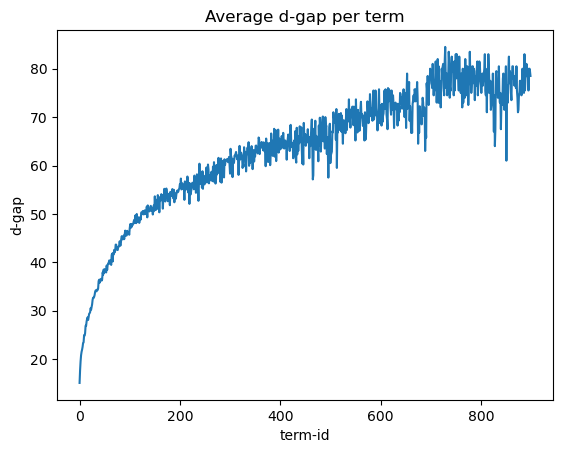

In [32]:
dgap.plot_avg_d_gap()

### Maximum *d*-gap per term plot

<class 'numpy.ndarray'>


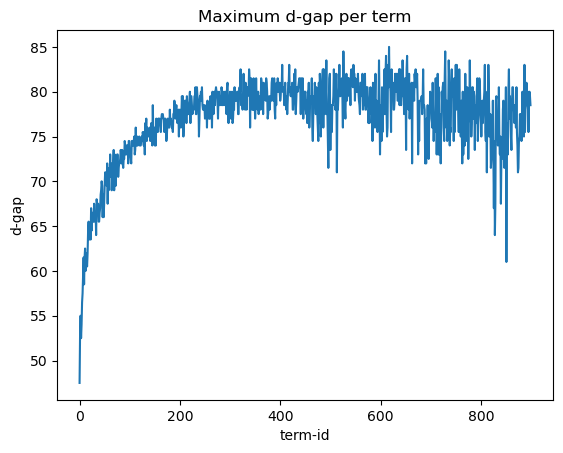

In [34]:
dgap.plot_max_d_gap()

### Overall statistics

In [24]:
print(f"Total d-gap: {gaps_stats['tot_d_gap']}")
print(f"Average d-gap: {gaps_stats['avg_d_gap']}")
print(f"Maximum d-gap: {gaps_stats['max_d_gap']}")

Total d-gap: 37907112
Average d-gap: 63.77
Maximum d-gap: 88


### Save statistics

We save statistics with in the directory with the specific configuration name: it will be no more necessary a second computation for further analysis.

In [25]:
dgap.save_stats()

INFO: Saving gaps information 
I/O: Created directory /home/sebaq/Documents/GitHub/IR_project/dataset/tiny
I/O: Saving /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/d-gap_stats.json 


## 4. Dimensionality reduction

Clustering and TSP are expensive in a high dimensional and sparse vector space. We employ the [Johnson-Lindenstrauss lemma](https://scikit-learn.org/stable/modules/random_projection.html#the-johnson-lindenstrauss-lemma) to embed data points in a lower dense dimensional space through a random projection. Target dimension depends on an approximation factor specified in Dataset configuration.

### Approximation factor

The approximation factor is in range [0, 1]

In [15]:
eps = config.eps
eps

0.3

In [16]:
embedded = collection.embed(eps=eps)
embedded.shape

(50000, 1202)

In [17]:
embedded

array([[ 0.01592837, -0.00976462, -0.02283739, ..., -0.00617229,
         0.01100428, -0.02905892],
       [-0.01607342, -0.0111482 , -0.02615699, ...,  0.        ,
         0.00571539, -0.0322051 ],
       [ 0.01112747, -0.00482762, -0.02314787, ...,  0.0017706 ,
         0.0031541 , -0.01486856],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

## 5. Clustering

### Compute number of clusters

We compute the number of cluster to find using a function specified in the configuration.

In [18]:
n_cluster = config.n_cluster
n_cluster

150

### Create K-Means instance

In [19]:
from model.clustering import KMeansClustering

kmeans = KMeansClustering(mat=embedded, data_name=config.name, k=n_cluster)

INFO: Try to retrieve labels info from disk
I/O: Loading /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/labeling.json 


In [20]:
kmeans

KMeansClustering[Items: 50000; k: 150;  Labeling computed: True]

### Training model and retrieve labeling

In [21]:
%%time

labels = kmeans.labels

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 14.5 µs


In [22]:
labels

array([91, 91, 91, ..., 69, 69, 69])

### Save labeling

We save labelings on disk for the specific collection for no need to compute again.

In [23]:
kmeans.save_labels()

I/O: Overwriting /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/labeling.json 


## 6. Cluster split

### Get CollectionCluster instance

We split data in cluster using the labeling.

In [24]:
from model.clustering import CollectionClusters

# collection_clusters = CollectionClusters(mat=collection.data, labels=kmeans.labels, data_name=config.name)
collection_clusters = kmeans.clusters

INFO: Try to retrieve medoids info from disk
I/O: Loading /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/medoids.npy. 


In [25]:
collection_clusters

ClusterDataSplit [Data: 50000, Clusters: 150, Mean-per-Cluster: 333.333; Medoids computed: True]

### Compute medoids

In [26]:
medoids = collection_clusters.medoids

In [27]:
medoids

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.65579394e-03,  5.79263463e-02,  4.86947937e-04, ...,
        -6.21756792e-04, -1.26874703e-04,  7.30596220e-05],
       [ 3.31141948e-03, -7.29662856e-04,  7.95110007e-04, ...,
        -5.79422843e-04,  3.67344510e-04, -3.16213334e-03],
       ...,
       [ 0.00000000e+00,  7.13129251e-03,  3.71318208e-03, ...,
         0.00000000e+00,  4.61268439e-03,  0.00000000e+00],
       [-1.95489364e-03, -7.47501509e-04, -5.93931430e-04, ...,
        -2.74614131e-04,  4.55944311e-04,  4.36976906e-03],
       [ 1.58938245e-03, -3.39167619e-03,  4.02028592e-04, ...,
        -7.01530323e-04, -1.77175524e-03,  7.06800952e-04]])

In [28]:
medoids.shape

(150, 1202)

### Save medoids

Save medoids on disk for the specific collection for no need to compute again.

In [29]:
collection_clusters.save_medoids()

INFO: Saving medoids 
I/O: Directory /home/sebaq/Documents/GitHub/IR_project/dataset/tiny already exists 
I/O: Overwriting /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/medoids.npy. 


### 8. TSP

In [57]:
from model.docid_reassignment import DocIdReordering

reordering = DocIdReordering(collection_clusters=collection_clusters, data_name=config.name)

I/O: Loading /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/order.json 


In [58]:
reordering.solve()

In [59]:
reordering.clusters_sol

{0: array([1, 0]),
 1: array([143, 145, 182, 120, 129, 131, 123,  52, 177, 179, 168, 171, 174,
        181, 170, 166, 165, 169, 125, 140, 121, 176, 172, 167, 180, 175,
        157, 124, 128, 130,  92, 117, 141,  57, 142, 162, 146, 155, 147,
        153, 148, 159, 160, 150, 152, 161, 158, 156, 163, 149, 154, 164,
        151, 138,  16, 178, 116, 133, 134,  27, 104,  46,  47,  65, 115,
         63, 105, 139,  80,  61, 136,  39,  26, 122,  37, 112, 113, 144,
         24, 108,  84,   0, 102,  32,  93,  19,  38,  62,  68,  90, 100,
         67,  83, 137,  44,  45,  15,  70,  13,  22,  91, 173,  66,  74,
        114,  23,  55,  11,  95,  96,  43,  73,  18,  86,  28,  72,   4,
         64,   2,  36,   8,  53,  78,   1,  20, 111,  33,  40,  89,  76,
         94,  98,  49,  87,  99,  42,  71,  85,  56,  10,  58,   3, 132,
         29, 135,  48,  81,  34,  31,  51,  82,  50,   9,  79,  30,  54,
        107,  97,  69, 127,  60,  25,  59,  14, 118,  17,   5, 110,   6,
         77, 106, 126, 101,  

In [60]:
reordering.save_order()

INFO: Saving order 
I/O: Directory /home/sebaq/Documents/GitHub/IR_project/dataset/tiny already exists 
I/O: Overwriting /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/order.json 


In [61]:
original_cluster = CollectionClusters(mat=collection.data, labels=labels, data_name=config.name)

INFO: Try to retrieve medoids info from disk
I/O: Loading /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/medoids.npy. 


In [62]:
from model.docid_reassignment import DocIdReassignment

reass = DocIdReassignment(cluster=original_cluster, medoid_order=reordering.medoids_sol, clusters_order=reordering.clusters_sol)

In [66]:
ordered = reass.reordered()

TypeError: only integer scalar arrays can be converted to a scalar index

In [73]:
n_cluster = original_cluster.n_cluster

clusters_reordered = [
    original_cluster[i][reordering.clusters_sol[i]]
    for i in range(n_cluster)
]

In [86]:
medoids_reordered =  [clusters_reordered[i] for i in reordering.medoids_sol]

In [91]:
from scipy.sparse import vstack

mat = vstack(medoids_reordered)

In [92]:
mat

<50000x14980 sparse matrix of type '<class 'numpy.float64'>'
	with 1314210 stored elements in Compressed Sparse Row format>

In [94]:
from model.dataset import DataCollection

new_one = DataCollection(mat=mat)

In [95]:
new_gap = DGapComputation(collection=new_one, data_name='aaa')

INFO: Try to retrieve gaps info from disk
INFO: Information is not available, need to be computed


In [96]:
new_gap.gaps_stats

INFO: Computing gaps per term


100%|██████████| 50000/50000 [00:03<00:00, 14886.09it/s]


{'tot_d_gap_pterm': array([167968, 164248, 162480, ...,     88,     88,     88]),
 'avg_d_gap_pterm': array([12.442, 13.282, 13.339, ..., 88.   , 88.   , 88.   ]),
 'max_d_gap_pterm': array([48, 48, 48, ..., 88, 88, 88]),
 'tot_d_gap': 34127640,
 'avg_d_gap': 62.727,
 'max_d_gap': 88}